In [1]:
import utils
import pandas as pd
import numpy as np

c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
LALONDE_COLS = ['treatment', 'age', 'education', 'black', 'hispanic', 'married','nodegree', 're74', 're78']

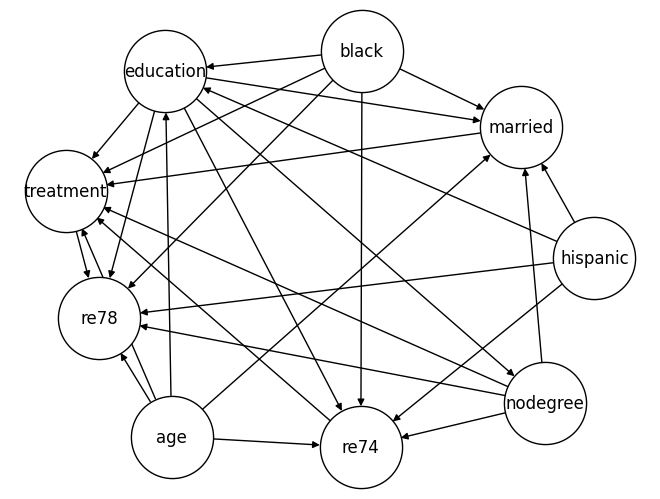

In [4]:
lalonde_original, nswre_df, cps_control, psid_control, cps2_control, cps3_control, psid2_control, psid3_control = utils.load_data()
nswre_cps, nswre_cps2, nswre_cps3, nswre_psid, nswre_psid2, nswre_psid3 = utils.load_combinations(nswre_df, cps_control, cps2_control, cps3_control,  psid_control, psid2_control, psid3_control)
lalonde_cps, lalonde_cps2, lalonde_cps3, lalonde_psid, lalonde_psid2, lalonde_psid3 = utils.load_combinations(lalonde_original, 
                                                                                                                           cps_control[LALONDE_COLS], 
                                                                                                                           cps2_control[LALONDE_COLS], 
                                                                                                                           cps3_control[LALONDE_COLS],  
                                                                                                                           psid_control[LALONDE_COLS], 
                                                                                                                           psid2_control[LALONDE_COLS], 
                                                                                                                           psid3_control[LALONDE_COLS])

graph = utils.extract_CD_graph("graph_1603") #Loads the graph from json
utils.draw_graph(graph) #plots the graph
combinations_dict = {"nswre_experiment": nswre_df, 
                     "nswre_cps": nswre_cps, 
                     "nswre_cps2": nswre_cps2, 
                     "nswre_cps3": nswre_cps3, 
                     "nswre_psid": nswre_psid, 
                     "nswre_psid2": nswre_psid2, 
                     "nswre_psid3": nswre_psid3}

## Baseline Check

Lalonde Baseline

In [5]:
lalonde_combinations_dict = {"lalonde_original": lalonde_original, 
                            "lalonde_cps": lalonde_cps, 
                            "lalonde_cps2": lalonde_cps2, 
                            "lalonde_cps3": lalonde_cps3, 
                            "lalonde_psid": lalonde_psid, 
                            "lalonde_psid2": lalonde_psid2, 
                            "lalonde_psid3": lalonde_psid3}

In [6]:
utils.baseline_1999(lalonde_combinations_dict, methods=["backdoor.linear_regression"], refuter_list=["data_subset_refuter", "placebo_treatment_refuter"])

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression
lalonde_original,treatment,re78,886.303731,866.932533,43.744190
lalonde_cps,treatment,re78,-8870.307640,-8815.755158,15.165878
lalonde_cps2,treatment,re78,-4194.758927,-4176.375730,-9.637551
lalonde_cps3,treatment,re78,-1007.817710,-1051.470713,-7.414822
lalonde_psid,treatment,re78,-15577.568966,-15632.481996,-7.006609
lalonde_psid2,treatment,re78,-4019.597945,-4024.059248,38.785953
lalonde_psid3,treatment,re78,697.058407,674.877600,32.152962


NSWRE Baseline

In [7]:
utils.baseline_1999(combinations_dict, methods=["backdoor.linear_regression"], refuter_list=["data_subset_refuter", "placebo_treatment_refuter"])

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression
nswre_experiment,treatment,re78,1794.342404,1808.098978,36.739548
nswre_cps,treatment,re78,-8497.516143,-8536.322836,-27.956380
nswre_cps2,treatment,re78,-3821.967430,-3802.456660,39.870156
nswre_cps3,treatment,re78,-635.026212,-656.718688,-134.431954
nswre_psid,treatment,re78,-15204.777468,-15164.302676,-56.441226
nswre_psid2,treatment,re78,-3646.806447,-3630.215058,262.640386
nswre_psid3,treatment,re78,1069.849904,1055.145136,-30.005945


In [8]:
backdoor_group, frontdoor_group, iv_group = utils.indentify_effects(graph, nswre_df, pairs=[("treatment", "re78")]) #, pairs=[("treatment", "re78")]

In [9]:
backdoor_group

,treatment,outcome,backdoor
0,treatment,re78,"[nodegree, black, hispanic, education, age]"


In [10]:
frontdoor_group

,treatment,outcome,backdoor,frontdoor,instrumental_variables


In [11]:
iv_group

,treatment,outcome,backdoor,frontdoor,instrumental_variables


In [12]:
backdoor_list = ["backdoor.linear_regression", 
                 #"backdoor.distance_matching",     # need to specify a distance metric
                 #"backdoor.propensity_score_stratification", # not enough data for some combinations 
                 #"backdoor.propensity_score_matching", # takes a lot of time 
                 "backdoor.propensity_score_weighting"]

backdoor_results = None
for i, row in backdoor_group.iterrows():
    print(row["treatment"], row["outcome"])
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=backdoor_list, 
                    refuter_list = ["data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if backdoor_results is None:
            backdoor_results = pd.DataFrame(columns=list(df.columns))

    backdoor_results = pd.concat([backdoor_results, df], axis=0)
  


treatment re78


In [13]:
backdoor_results

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression,backdoor.propensity_score_weighting,data_subset_refuterbackdoor.propensity_score_weighting,placebo_treatment_refuterbackdoor.propensity_score_weighting
nswre_experiment,treatment,re78,1676.083104,1702.95,1.95,1647.525255,1593.22,221.08
nswre_cps,treatment,re78,-4285.482110,4308.98,27.96,-7532.327097,7587.89,238.84
nswre_cps2,treatment,re78,-1216.906557,1250.12,32.04,-2893.901324,2921.18,723.16
nswre_cps3,treatment,re78,829.258143,803.12,30.66,282.799328,251.20,951.56
nswre_psid,treatment,re78,-8453.472661,8460.59,28.83,-13652.094219,13711.28,2651.87
nswre_psid2,treatment,re78,-2568.819934,2552.84,57.28,-2421.952828,2443.01,2597.95
nswre_psid3,treatment,re78,690.836648,646.23,173.90,1002.390721,1030.93,1092.04


In [22]:
# frontdoor.two_stage_regression
#frontdoor_list = ["frontdoor.two_stage_regression"] # Need on only one var in the conditioning set
frontdoor_list = ["frontdoor.linear_regression", 
                 #"backdoor.distance_matching",     # need to specify a distance metric
                 #"backdoor.propensity_score_stratification", # not enough data for some combinations 
                 #"backdoor.propensity_score_matching", # takes a lot of time 
                 "frontdoor.propensity_score_weighting"]

# Couldnt make it work

frontdoor_results = None
for i, row in frontdoor_group.iterrows():
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=frontdoor_list, 
                    refuter_list = ["bootstrap_refuter", "data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if frontdoor_results is None:
            frontdoor_results = pd.DataFrame(columns=list(df.columns))

    frontdoor_results = pd.concat([frontdoor_results, df], axis=0)

In [ ]:
frontdoor_results

In [23]:
iv_list = ["iv.instrumental_variable", "iv.regression_discontinuity"]

iv_results = None
for i, row in iv_group.iterrows():
    # We cannot use continuous treatment for propensity score
    if row["treatment"] not in ["re74", "re75", "re78", "education"]:
        df = utils.causal_effect(combinations_dict, 
                    graph, 
                    methods=iv_list, 
                    refuter_list = ["bootstrap_refuter", "data_subset_refuter", "placebo_treatment_refuter"], 
                    treatment= row["treatment"],
                    outcome= row["outcome"])
        if iv_results is None:
            iv_results = pd.DataFrame(columns=list(df.columns))

    iv_results = pd.concat([iv_results, df], axis=0)


In [24]:
iv_results

,treatment,outcome,backdoor.linear_regression,data_subset_refuterbackdoor.linear_regression,placebo_treatment_refuterbackdoor.linear_regression,backdoor.propensity_score_weighting,data_subset_refuterbackdoor.propensity_score_weighting,placebo_treatment_refuterbackdoor.propensity_score_weighting
nswre_experiment,nodegree,re78,-867.569874,845.951286,49.872439,-1802.627940,1771.111644,259.642039
nswre_cps,nodegree,re78,-2597.408790,2579.201130,2.833990,-2694.583283,2687.829835,275.179681
nswre_cps2,nodegree,re78,-2207.181223,2198.441049,4.248702,-1431.454741,1426.733083,1730.909798
nswre_cps3,nodegree,re78,-886.077317,817.378472,12.944576,-1368.090694,1367.995961,1294.673267
nswre_psid,nodegree,re78,-1264.149806,1262.374176,37.055810,-6000.451722,5975.389743,4348.678623
nswre_psid2,nodegree,re78,-2606.284300,2627.326615,8.240389,-264.511964,376.666054,7842.451114
nswre_psid3,nodegree,re78,-186.589556,98.179205,52.679177,-2467.654036,2392.104380,884.313046
